PCA implementation from scratch

In [2]:
import argparse
import sys
import os
import numpy as np
from numpy.linalg import qr
import matplotlib.pyplot as plt
from matplotlib import transforms
from copy import deepcopy

In [355]:
class PCA_analysis(object):

    def __init__(self, data, n_components):
      self.data = data
      self.S = np.matmul(self.data, self.data.T)
      self.components = n_components

    def cov_matrix(self):
      return np.cov(self.data)

    def get_eigen_QR(self, iterations):
        XXT = self.S
        for i in range(iterations):
            q, r = qr(XXT)
            XXT = np.dot(r, q)
        return XXT

    def get_eigen(self, e = np.ones([10368,1]), accuracy = 0.001, iterations=100):
        '''
            Iterative method to get 
            largest eigen value and vector 
            (Power Method) 
        '''
        S = self.S
        p = np.matmul(S, e)
        eigen_val = np.max(np.abs(p))
        e_current = p/eigen_val
        error = 100*accuracy
        i = 0
        while (iterations > i):
            p = np.matmul(S, e_current)
            eigen_val = np.max(np.abs(p))
            e_previous = e_current
            e_current = p/eigen_val
            error = abs(np.linalg.norm(e_current)-np.linalg.norm(e_previous))
            if error < accuracy:
                return e_current, eigen_val
            i +=1
        return e_current, eigen_val

    def get_top_eigens(self, top=3, accuracy = 0.000000000001, max_iter=100):
        S = self.S
        eigen_values = []
        eigen_vectors = np.array([])
        orthogonal_x = np.ones([S.shape[0],1])
        for i in range(top):
            eigen_vect, eigen_val = self.get_eigen(S, 
                                                  e=orthogonal_x, 
                                                  accuracy = accuracy, 
                                                  iterations=max_iter)
            eigen_values.append(eigen_val)
            eigen_vectors = np.append(eigen_vectors, eigen_vect)
            # generate the orthogonal one
            orthogonal_x = np.random.rand(S.shape[0])
            orthogonal_x = np.reshape(orthogonal_x, newshape=(S.shape[0],1))
            orthogonal_x = orthogonal_x - np.dot(orthogonal_x.T, eigen_vect) * eigen_vect
            orthogonal_x /= np.linalg.norm(orthogonal_x)
            orthogonal_x = np.cross(eigen_vect, orthogonal_x)
        return eigen_values, eigen_vectors

    def eig_sparse(self, top=3):
        from scipy.sparse.linalg import eigs
        vals, vecs = eigs(self.S, k=top)
        return vals, vecs
    
    def fit_transform(self):
        eigen_values, eigen_vectors = self.eig_sparse(top=self.components)
        transformed_data = np.matmul(eigen_vectors.T, self.data)
        return transformed_data, eigen_vectors

    def plot_map(self, transformed_data, eigen_vectors, fig_name, map_color, day=30, map_shape = (144, 72)):
        day -= 1
        time_data = np.array([])
        td = transformed_data[0,:]
        td = np.reshape(td, (366, 1))
        map = td[day]*eigen_vectors[:,0]
        for i in range(1, self.components):
          td = transformed_data[i,:]
          td = np.reshape(td, (366, 1))
          map += td[day]*eigen_vectors[:,i]
        self.plot(np.real(map), fig_name, map_color=map_color)
        return None

    def plot(self, datax, fig_name, map_color, map_shape = (144, 72)):
        datax = np.reshape(datax, map_shape)
        datax = np.rot90(datax)
        plt.title(str(fig_name))
        im = plt.imshow(datax, cmap=map_color, interpolation='bilinear')
        plt.colorbar(im)
        plt.savefig(str(fig_name)+str('.png'), format='png', dpi=200)
        plt.show()
        return None

    def plot_amplitudes(self, transformed_data, fig_name):
        for i in range(self.components):
            plt.title(str(fig_name)+str(' corresponding to Eig=')+str(i+1))
            plt.plot(transformed_data[i, :])
            plt.savefig(str(fig_name)+str('_')+str(i+1)+str('.png'), format='png', dpi=200)
            plt.show()
        return None

    def plot_EOFs(self, eigen_vectors, fig_name, map_color='coolwarm', map_shape = (144, 72)):
        for i in range(self.components):
            datax = np.reshape(np.real(eigen_vectors[:,i]), map_shape)
            datax = np.rot90(datax)
            plt.title(str(fig_name)+str(' ')+str(i+1))
            im = plt.imshow(datax, cmap=map_color, interpolation='none')
            plt.savefig(str(fig_name)+str('_')+str(i+1)+str('.png'), format='png', dpi=200)
            plt.show()
        return None

    def lower_bound_var(self):
        # Calculate lower-bound of variance explained
        eigen_values, eigen_vectors = self.eig_sparse(top=self.components)
        sum_eig_val = np.sum(eigen_values) + (10368-self.components)*eigen_values[-1]
        return np.sum(np.real(eigen_values[0:self.components])/np.real(sum_eig_val))


In [ ]:
pca_ta = PCA_analysis(ta_year.data, n_components=4)
transformed_data, eigen_vectors = pca_ta.fit_transform()

# Some example results in some weather datasets
Original data vs PCA transformed data (reduced)

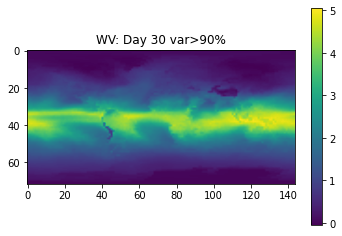

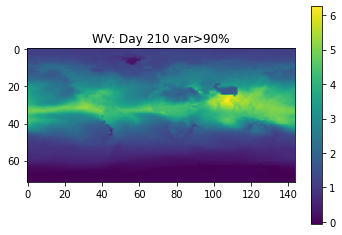

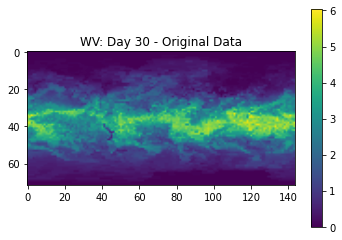

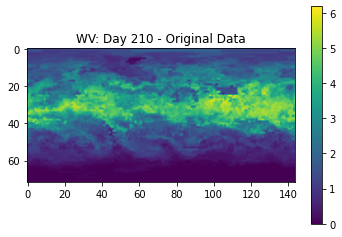

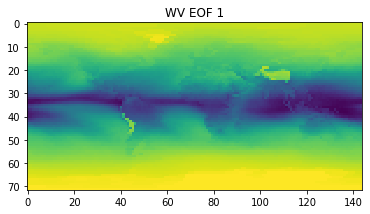

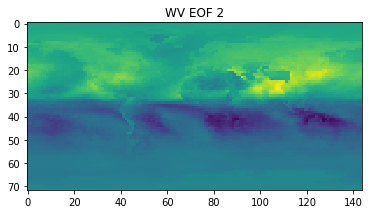

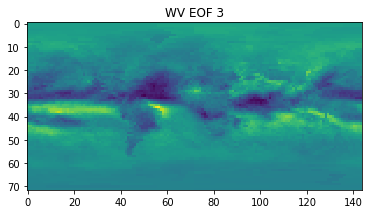

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


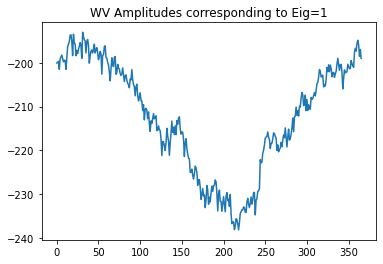

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


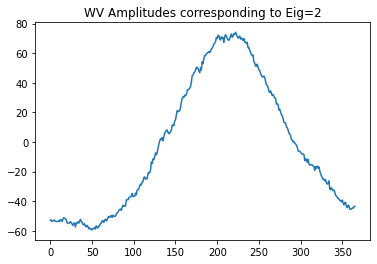

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


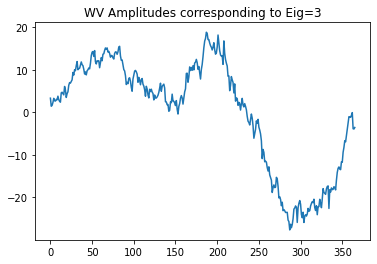

In [412]:
pca_wv = PCA_analysis(wv_year.data, n_components=3)
transformed_data, eigen_vectors = pca_wv.fit_transform()
pca_wv.plot_map(transformed_data, eigen_vectors, 'WV: Day 30 var>90%', map_color='viridis', day=30, map_shape = (144, 72))
pca_wv.plot_map(transformed_data, eigen_vectors, 'WV: Day 210 var>90%', map_color='viridis', day=210, map_shape = (144, 72))
plotter_object.plot_map(pca_wv.data[:,30], fig_name='WV: Day 30 - Original Data', map_color='viridis')
plotter_object.plot_map(pca_wv.data[:,210], fig_name='WV: Day 210 - Original Data', map_color='viridis')
pca_wv.plot_EOFs(eigen_vectors, 'WV EOF', 'viridis')
pca_wv.plot_amplitudes(transformed_data, 'WV Amplitudes')